In [1]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# QT Complexity Engine v0.2 — Canvas 1
# Section: Environment Setup and Global Configuration

"""
This cell defines the environment, global parameters, and reproducibility settings
for the QT Complexity Engine v0.2.
All comments are required to be in English.
"""

import numpy as np
import random
import os
import math

# -----------------------------
# Global Configuration Settings
# -----------------------------

CONFIG = {
    "RANDOM_SEED": 42,             # Global reproducibility seed
    "MAX_NEIGHBORS": 32,           # Max neighbors sampled for entropy and curvature
    "MAX_CURVATURE_SAMPLES": 32,   # Pairwise samples for W1 curvature approximation
    "DEFAULT_STEPS": 1000,         # Default random-walk trajectory length

    # GPU / Tensor Patch Configuration
    "USE_GPU": True,               # Enable PyTorch tensor acceleration
    "GPU_DEVICE": "cuda",          # Device selector ("cpu", "cuda", "cuda:0")
    "BATCH_KAPPA": True,           # Compute geometric curvature via batched flips
    "BATCH_SIZE_KAPPA": 256,       # Batch size for kappa evaluation
}

# Apply seeds for reproducibility
np.random.seed(CONFIG["RANDOM_SEED"])
random.seed(CONFIG["RANDOM_SEED"])

print("Environment initialized. Global configuration loaded.")

Environment initialized. Global configuration loaded.


In [2]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# QT Complexity Engine v0.2 — Canvas 2
# Section: Imports and Version Report

"""
This cell loads all required libraries for the QT Complexity Engine v0.2.
It also prints their versions so engineers can guarantee reproducibility
when running the engine in Colab or a local Jupyter environment.
All comments must remain in English.
"""

import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
import json
import torch  # Added for GPU Patch

# Print version report for reproducibility
print("--- Library Version Report ---")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"NetworkX version: {nx.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print("Random module: built-in Python library")
print(f"tqdm version: {tqdm.__version__}")
print("--------------------------------")

--- Library Version Report ---
NumPy version: 2.0.2
Pandas version: 2.2.2
Matplotlib version: 3.10.0
NetworkX version: 3.6
PyTorch version: 2.9.0+cu126
CUDA Available: True
Random module: built-in Python library
tqdm version: 4.67.1
--------------------------------


In [3]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 3 — QT Complexity Engine v0.2
# Section: Core Data Structures — Base Problem Interface

"""
This cell defines the abstract base class for all problem instances used in
QT Complexity Engine v0.2. Every problem type (SAT, MaxCut, TSP, Custom JSON)
will inherit from this interface.
All comments must remain in English.
"""

from typing import List, Tuple

class QTProblemInstance:
    """
    Abstract interface for all QT Complexity Engine problem types.
    Each specific adapter must implement:
      - num_variables(): return dimensionality n of {0,1}^n
      - evaluate(x): return structural quality C(x) normalized to [0,1]
      - neighbors(x): return Hamming-1 neighborhood of a state x
    """

    def num_variables(self) -> int:
        raise NotImplementedError("num_variables() must be implemented in subclass.")

    def evaluate(self, x: Tuple[int, ...]) -> float:
        raise NotImplementedError("evaluate() must be implemented in subclass.")

    def neighbors(self, x: Tuple[int, ...]) -> List[Tuple[int, ...]]:
        raise NotImplementedError("neighbors() must be implemented in subclass.")

print("Base QTProblemInstance interface loaded.")


Base QTProblemInstance interface loaded.


In [4]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 4 — QT Complexity Engine v0.2
# Section: Utility Functions — State Representation & Neighborhood Sampling

"""
This cell defines helper functions used across all modules of QT Complexity Engine v0.2.
Includes:
  - random_initial_state(n): create a random binary vector of length n
  - sample_neighbors(): sampling wrapper to reduce computational load
All comments must remain in English.
"""

import numpy as np
import random
from typing import List, Tuple

# --------------------------------------------------
# Generate a random binary state of dimension n
# --------------------------------------------------

def random_initial_state(n: int) -> Tuple[int, ...]:
    """
    Returns a uniformly sampled binary vector of length n.
    The state is represented as an immutable tuple for hashing and stability.
    """
    return tuple(np.random.randint(0, 2, size=n))

# --------------------------------------------------
# Neighbor sampling to control computational cost
# --------------------------------------------------

def sample_neighbors(problem, x: Tuple[int, ...], max_neighbors: int = 32) -> List[Tuple[int, ...]]:
    """
    Returns either the full Hamming-1 neighborhood or a sampled subset
    if the neighborhood size exceeds max_neighbors.
    """
    full = problem.neighbors(x)
    if len(full) <= max_neighbors:
        return full
    return random.sample(full, max_neighbors)

print("Utility functions for state initialization and neighbor sampling loaded.")


Utility functions for state initialization and neighbor sampling loaded.


In [5]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 5 — QT Complexity Engine v0.2
# Section: Problem Adapters — SAT (2-SAT & 3-SAT) DIMACS Parser and Structural Quality

"""
This cell implements the SAT problem adapters for the QT Complexity Engine v0.2.
Supported formats: DIMACS CNF for 2-SAT and 3-SAT.
Implements:
  - DIMACS parser
  - QT2SATInstance
  - QT3SATInstance

Patch Update:
  - Added export_tensor_structure() to support QTBackend tensor encoding.
"""

from typing import List, Tuple
import torch

# --------------------------------------------------
# DIMACS CNF Parser
# --------------------------------------------------

def parse_dimacs(path: str):
    """
    Updated DIMACS parser supporting:
      - 'c' comments
      - '%' comments
      - proper 'p cnf <vars> <clauses>' header
      - safe clause parsing with warnings
    """
    clauses = []
    num_vars = None
    num_clauses_declared = None

    with open(path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith("c") or line.startswith("%"):
                continue
            if line.lower().startswith("p cnf"):
                parts = line.split()
                num_vars = int(parts[2])
                num_clauses_declared = int(parts[3])
                continue

            parts = line.split()
            try:
                # Remove '0' terminator if present
                literals = [int(x) for x in parts if x != "0"]
            except ValueError as e:
                print(f"[ERROR] Failed to parse clause line: {line}")
                raise e

            if literals:
                clauses.append(literals)

    if num_vars is None:
        # Fallback inference if header missing (rare)
        max_v = 0
        for c in clauses:
            for l in c:
                if abs(l) > max_v: max_v = abs(l)
        num_vars = max_v
        print(f"[WARNING] DIMACS header missing. Inferred num_vars={num_vars}")

    return num_vars, clauses


# --------------------------------------------------
# Base SAT Adapter Class
# --------------------------------------------------
class QTSATBase(QTProblemInstance):
    """
    Shared logic for SAT instances.
    """

    def __init__(self, cnf_path: str):
        self.num_vars, self.clauses = parse_dimacs(cnf_path)
        self.M = len(self.clauses)
        self.n = self.num_vars

    def num_variables(self) -> int:
        return self.n

    def evaluate(self, x: Tuple[int, ...]) -> float:
        """
        Computes structural quality C(x): fraction of satisfied clauses.
        C(x) = sat_count / M, always normalized to [0, 1].
        Legacy CPU implementation.
        """
        sat_count = 0
        for clause in self.clauses:
            satisfied = False
            for lit in clause:
                var_idx = abs(lit) - 1
                # Check bounds just in case
                if var_idx >= len(x): continue

                var_val = x[var_idx]
                if (lit > 0 and var_val == 1) or (lit < 0 and var_val == 0):
                    satisfied = True
                    break
            if satisfied:
                sat_count += 1
        return sat_count / self.M

    def neighbors(self, x: Tuple[int, ...]) -> List[Tuple[int, ...]]:
        """
        Classic Hamming-1 neighborhood: flip exactly one variable.
        Legacy CPU implementation.
        """
        x_list = list(x)
        neigh = []
        for i in range(self.n):
            y = x_list.copy()
            y[i] = 1 - y[i]
            neigh.append(tuple(y))
        return neigh

    # --- GPU Patch: Tensor Encoding ---
    def export_tensor_structure(self, device: str) -> torch.Tensor:
        """
        Converts clauses list to a sparse-like matrix for tensor operations.
        Matrix Shape: [num_clauses, num_vars]
        Values:
             +1 : Variable appears positive
             -1 : Variable appears negative
              0 : Variable not present
        """
        # We construct this on CPU first then move to device
        # Using int8 to save memory, though float might be needed for matmul
        clause_matrix = torch.zeros((self.M, self.n), dtype=torch.float32)

        for i, clause in enumerate(self.clauses):
            for lit in clause:
                var_idx = abs(lit) - 1
                if var_idx < self.n:
                    sign = 1.0 if lit > 0 else -1.0
                    clause_matrix[i, var_idx] = sign

        return clause_matrix.to(device)


# --------------------------------------------------
# Specific Adapters for 2-SAT and 3-SAT
# --------------------------------------------------
class QT2SATInstance(QTSATBase):
    pass

class QT3SATInstance(QTSATBase):
    pass


print("SAT problem adapters (2-SAT / 3-SAT) loaded [Patched for Tensor Support].")

SAT problem adapters (2-SAT / 3-SAT) loaded [Patched for Tensor Support].


In [6]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 6 — QT Complexity Engine v0.2
# Section: Problem Adapter — MaxCut (Graph-based Structural Quality)

"""
This cell implements the MaxCut problem adapter for QT Complexity Engine v0.2.
Supports:
  - Graph loading from edge list file or synthetic construction
  - Structural quality C(x) = W_cut / W_total normalized to [0,1]
  - Hamming-1 neighborhood over node partitions
All comments remain in English.
"""

from typing import List, Tuple
import networkx as nx


class QTMaxCutInstance(QTProblemInstance):
    """
    MaxCut problem adapter.
    State representation:
        x[i] in {0,1} assigns node i to one of two partitions.
    Structural quality:
        C(x) = W_cut(x) / W_total
    """

    def __init__(self, edge_list_path: str = None, graph: nx.Graph = None):
        if graph is not None:
            self.G = graph
        else:
            self.G = nx.Graph()
            with open(edge_list_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if not parts:
                        continue
                    u = int(parts[0])
                    v = int(parts[1])
                    if len(parts) == 3:
                        w = float(parts[2])
                    else:
                        w = 1.0
                    self.G.add_edge(u, v, weight=w)

        self.n = self.G.number_of_nodes()
        self.W_total = sum(d.get("weight", 1.0) for _, _, d in self.G.edges(data=True))

    def num_variables(self) -> int:
        return self.n

    def evaluate(self, x: Tuple[int, ...]) -> float:
        """
        Computes C(x) for MaxCut: fraction of edge weight cut.
        """
        cut_weight = 0.0
        for u, v, d in self.G.edges(data=True):
            w = d.get("weight", 1.0)
            if x[u] != x[v]:
                cut_weight += w
        return cut_weight / self.W_total if self.W_total > 0 else 0.0

    def neighbors(self, x: Tuple[int, ...]) -> List[Tuple[int, ...]]:
        x_list = list(x)
        neigh = []
        for i in range(self.n):
            y = x_list.copy()
            y[i] = 1 - y[i]
            neigh.append(tuple(y))
        return neigh


print("MaxCut adapter loaded.")

MaxCut adapter loaded.


In [7]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 7 — QT Complexity Engine v0.2
# Section: Problem Adapter — TSP (Simplified Binary/Permutation Hybrid Encoding)

"""
This cell implements a simplified TSP adapter suitable for QT Complexity Engine v0.2.
Because TSP is not naturally binary, we adopt a hybrid strategy:
    - Internal representation: a permutation (tour)
    - External interface for QT engine: binary encoding representing edges
This allows the engine to treat TSP states as binary vectors while still computing
valid tour lengths.

NOTE:
    For v0.2, TSP is recommended only for small instances (n <= 10) due to combinatorics.
All comments must remain in English.
"""

from typing import List, Tuple
import numpy as np


class QTTSPInstance(QTProblemInstance):
    """
    Simplified TSP adapter.
    Internal representation is a permutation of n cities.
    Binary encoding: x encodes bidirectional edges in adjacency form.
    """

    def __init__(self, distance_matrix: np.ndarray):
        assert distance_matrix.shape[0] == distance_matrix.shape[1], "Matrix must be square."
        self.D = distance_matrix
        self.n = distance_matrix.shape[0]

        # Precompute theoretical min/max bounds heuristically using sampling
        self.L_min, self.L_max = self._estimate_bounds(samples=200)

    def num_variables(self) -> int:
        # Binary encoding uses n*n entries: connection matrix
        return self.n * self.n

    # --------------------------------------------------
    # Structural Quality
    # --------------------------------------------------
    def evaluate(self, x: Tuple[int, ...]) -> float:
        """
        Converts a binary vector x into a tour, computes its length,
        and returns normalized structural quality:
            C(x) = 1 - (L(x) - L_min) / (L_max - L_min + eps)
        """
        eps = 1e-9
        tour = self._binary_to_tour(x)
        Lx = self._tour_length(tour)
        return 1 - (Lx - self.L_min) / (self.L_max - self.L_min + eps)

    # --------------------------------------------------
    # Neighborhood (binary) — Hamming-1
    # --------------------------------------------------
    def neighbors(self, x: Tuple[int, ...]) -> List[Tuple[int, ...]]:
        neigh = []
        x_list = list(x)
        for i in range(len(x_list)):
            y = x_list.copy()
            y[i] = 1 - y[i]
            neigh.append(tuple(y))
        return neigh

    # --------------------------------------------------
    # Helper: convert binary state into a tour
    # --------------------------------------------------
    def _binary_to_tour(self, x: Tuple[int, ...]) -> List[int]:
        """
        Converts n*n binary vector into an approximate Hamiltonian cycle by:
        1) interpreting x as adjacency weights
        2) greedily selecting lowest-weight outgoing edges
        """
        M = self.n
        matrix = np.array(x).reshape(M, M)

        visited = set()
        tour = [0]
        visited.add(0)

        for _ in range(M - 1):
            current = tour[-1]
            # Select next unvisited city with binary = 1, fallback to nearest
            candidates = [j for j in range(M) if matrix[current, j] == 1 and j not in visited]
            if not candidates:
                # fallback: nearest unvisited
                dists = [(j, self.D[current, j]) for j in range(M) if j not in visited]
                next_city = min(dists, key=lambda z: z[1])[0]
            else:
                next_city = candidates[0]
            visited.add(next_city)
            tour.append(next_city)

        return tour

    # --------------------------------------------------
    # Helper: compute tour length
    # --------------------------------------------------
    def _tour_length(self, tour: List[int]) -> float:
        length = 0.0
        for i in range(len(tour)):
            a = tour[i]
            b = tour[(i + 1) % len(tour)]
            length += self.D[a, b]
        return length

    # --------------------------------------------------
    # Helper: estimate min/max bounds for normalization
    # --------------------------------------------------
    def _estimate_bounds(self, samples: int = 200):
        n = self.n
        best = float("inf")
        worst = 0.0

        for _ in range(samples):
            perm = np.random.permutation(n)
            L = self._tour_length(perm)
            best = min(best, L)
            worst = max(worst, L)

        return best, worst


print("TSP adapter loaded.")

TSP adapter loaded.


In [8]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 8 — QT Complexity Engine v0.2
# Section: Problem Adapter — Custom JSON Problem Loader

"""
This cell implements the Custom JSON problem adapter for QT Complexity Engine v0.2.
This allows users to define arbitrary problem structures via a simple JSON schema.
Supported evaluation modes:
    - "linear": C(x) = normalized weighted sum
    - "lookup": explicit mapping from bitstrings to scores
Hamming-1 neighborhood is used by default.
All comments must remain in English.
"""

import json
from typing import List, Tuple
import numpy as np


class QTCustomProblemInstance(QTProblemInstance):
    """
    Custom problem instance defined via JSON.
    JSON schema example:
        {
          "name": "toy-problem",
          "n": 64,
          "evaluation": {
            "type": "linear",
            "weights": [...]
          },
          "neighbors": {
            "type": "hamming1"
          }
        }
    """

    def __init__(self, json_path: str):
        with open(json_path, "r") as f:
            data = json.load(f)

        self.name = data.get("name", "custom")
        self.n = int(data["n"])

        # evaluation block
        self.eval_type = data["evaluation"]["type"]

        if self.eval_type == "linear":
            self.weights = np.array(data["evaluation"]["weights"], dtype=float)
            assert len(self.weights) == self.n, "weights length must equal n"

        elif self.eval_type == "lookup":
            # Expect mapping from string bitstrings to quality in [0,1]
            self.lookup_table = data["evaluation"]["table"]
        else:
            raise ValueError(f"Unknown evaluation type: {self.eval_type}")

        # neighbors block (currently only Hamming-1)
        self.neigh_type = data["neighbors"].get("type", "hamming1")

    def num_variables(self) -> int:
        return self.n

    # --------------------------------------------------
    # Structural Quality
    # --------------------------------------------------
    def evaluate(self, x: Tuple[int, ...]) -> float:
        if self.eval_type == "linear":
            # Weighted dot-product normalized to [0,1]
            score = np.dot(self.weights, np.array(x))
            max_score = np.sum(np.abs(self.weights)) + 1e-9
            return float(score / max_score)

        elif self.eval_type == "lookup":
            key = "".join(str(b) for b in x)
            return float(self.lookup_table.get(key, 0.0))

        else:
            raise ValueError(f"Unknown eval_type: {self.eval_type}")

    # --------------------------------------------------
    # Neighborhood (Hamming-1)
    # --------------------------------------------------
    def neighbors(self, x: Tuple[int, ...]) -> List[Tuple[int, ...]]:
        x_list = list(x)
        neigh = []
        for i in range(self.n):
            y = x_list.copy()
            y[i] = 1 - y[i]
            neigh.append(tuple(y))
        return neigh


print("Custom JSON problem adapter loaded.")

Custom JSON problem adapter loaded.


In [9]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 9 — QT Complexity Engine v0.2
# Section: Metric — Structural Quality Wrapper (C(x))

"""
This cell provides the unified structural quality computation function used
by the QT Complexity Engine. Each problem instance already implements its own
structural quality logic via evaluate(x), but the engine calls this wrapper
for clarity and consistency.
All comments remain in English.
"""

from typing import Tuple


def compute_structural_quality(problem: QTProblemInstance,
                               x: Tuple[int, ...]) -> float:
    """
    Calls problem.evaluate(x) and returns structural quality C(x).
    All C(x) values must be normalized into the interval [0,1] by the adapter.
    """
    Cx = problem.evaluate(x)

    # Safety clamp (should not trigger if adapters are correct)
    if Cx < 0:
        Cx = 0.0
    if Cx > 1:
        Cx = 1.0

    return float(Cx)


print("Structural Quality wrapper loaded.")

Structural Quality wrapper loaded.


In [10]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 10 — QT Complexity Engine v0.2
# Section: Metric — Local Entropy H_norm(x) (FIXED SOFTMAX)

"""
This cell implements the Quant-Trika local entropy metric H_norm(x).

FIX NOTES:
  - Re-introduced Boltzmann/Softmax weighting (temperature scaling).
  - In SAT, neighbor qualities C(y) are very close (e.g., 0.80 vs 0.81).
  - Without beta scaling, p(y) looks uniform, causing H to saturate at 1.0.
  - Beta amplifies these small differences: w_i = exp(beta * C_i).
  - Normalization stays strictly in [0, 1].
"""

import numpy as np
import math
from typing import Tuple, List

def compute_entropy(problem: QTProblemInstance,
                    x: Tuple[int, ...],
                    max_neighbors: int = 32,
                    beta: float = 50.0,  # Higher beta = more sensitive to small differences
                    return_raw: bool = False) -> float | tuple[float, float]:
    """
    Compute local Shannon entropy with Temperature Scaling.

    Args:
        beta: Inverse temperature.
              beta=0 -> Uniform distribution (H=1.0).
              beta large -> Greedy selection (H->0.0).
              Recommended for SAT: 50.0 - 100.0.
    """
    # 1. Generate neighborhood (1-bit flips)
    neighbors: List[Tuple[int, ...]] = sample_neighbors(
        problem, x, max_neighbors=max_neighbors
    )

    if not neighbors:
        if return_raw: return 0.0, 0.0
        return 0.0

    # 2. Compute structural qualities
    qualities = []
    for y in neighbors:
        # Clamp C(y) to [0,1] just in case
        Cy = max(0.0, min(1.0, compute_structural_quality(problem, y)))
        qualities.append(Cy)

    qualities = np.array(qualities, dtype=float)

    # 3. Apply Softmax (Boltzmann distribution)
    # Shift by max for numerical stability: exp(beta * (q - q_max))
    max_q = qualities.max()

    # Check for flat landscape (identical neighbors)
    # If diff is tiny, it's effectively uniform
    if qualities.max() - qualities.min() < 1e-9:
         # If all neighbors are equal, entropy is maximal (we don't know where to go)
        H_norm = 1.0
        H_raw = np.log2(len(qualities))
    else:
        # Weighted distribution
        weights = np.exp(beta * (qualities - max_q))
        Z = weights.sum()
        p = weights / Z

        # 4. Shannon entropy (base 2)
        eps = 1e-12
        plogp = p * np.log2(p + eps)
        H_raw = -float(plogp.sum())

        # 5. Normalize
        M = len(p)
        H_max = np.log2(M) if M > 1 else 1.0

        if H_max <= 0.0:
            H_norm = 0.0
        else:
            H_norm = H_raw / H_max

    # Clamp strictly to [0, 1]
    H_norm = max(0.0, min(1.0, H_norm))

    if return_raw:
        return float(H_norm), float(H_raw)
    return float(H_norm)

print("Entropy metric H_norm(x) loaded (Softmax Fixed).")

Entropy metric H_norm(x) loaded (Softmax Fixed).


In [11]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 11 — QT Complexity Engine v0.2
# Section: Metric — Coherence KQ(x) = C(x) * (1 - H_norm(x)) (PATCHED)

"""
This cell implements the Quant-Trika Coherence metric:
    KQ(x) = C(x) * (1 - H_norm(x))
Where:
    C(x) is structural quality in [0,1]
    H_norm(x) is normalized entropy in [0,1]
Thus KQ(x) ∈ [0,1].

All comments must remain in English.
"""

from typing import Tuple

def compute_coherence(problem: QTProblemInstance,
                      x: Tuple[int, ...],
                      max_neighbors: int = 32) -> float:
    """
    Computes coherence KQ(x) using:
        - structural quality C(x)
        - normalized entropy H_norm(x)
    """
    Cx = compute_structural_quality(problem, x)

    # Note: compute_entropy now returns strictly [0,1]
    H_norm = compute_entropy(problem, x,
                             max_neighbors=max_neighbors,
                             return_raw=False)

    KQx = Cx * (1.0 - H_norm)

    # Clamp safety
    if KQx < 0.0:
        KQx = 0.0
    if KQx > 1.0:
        KQx = 1.0

    return float(KQx)

print("Coherence metric KQ(x) loaded (PATCHED version).")

Coherence metric KQ(x) loaded (PATCHED version).


In [12]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 12 — QT Complexity Engine v0.2
# Section: Metric — Kappa (Stability/Curvature Tracker) (PATCHED)

"""
This cell implements the 'kappa' metric using a sliding window approach over H_norm.

Idea:
    - Tracks a sliding window of H_norm values.
    - High variance of H_norm in window => landscape is 'rough' => low kappa.
    - Low variance => landscape locally smooth => high kappa.
    - Kappa is normalized to [0, 1].
"""

import numpy as np
from collections import deque

def make_kappa_tracker(window_size: int = 32):
    """
    Returns a closure that tracks a sliding window of H_norm values and
    computes a curvature-like stability measure kappa in [0,1].
    """
    window = deque(maxlen=window_size)

    def update_and_get_kappa(h_norm_value: float) -> float:
        window.append(h_norm_value)
        if len(window) < 2:
            return 1.0  # not enough data -> assume smooth

        arr = np.asarray(window, dtype=float)
        # Calculate variance
        var = float(arr.var(ddof=0))

        # Normalize variance to [0,1] by dividing by max possible variance of a [0,1] variable.
        # For a bounded distribution on [0,1], max variance is 0.25 (Bernoulli p=0.5).
        max_var = 0.25

        # Ratio of current variance to max variance
        norm_var = min(var / max_var, 1.0)

        # Kappa is inverse of roughness (1 = smooth/stable, 0 = chaotic/rough)
        kappa = 1.0 - norm_var

        if kappa < 0.0:
            kappa = 0.0
        if kappa > 1.0:
            kappa = 1.0
        return float(kappa)

    return update_and_get_kappa

print("Kappa metric tracker loaded (PATCHED version).")

Kappa metric tracker loaded (PATCHED version).


In [13]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 12a — QT Complexity Engine v0.2
# Section: Core Compute API — GPU Backend (Patch-TZ)

"""
This cell implements the QTBackend class for GPU-accelerated metric computation using PyTorch.
It handles state representation as tensors {-1, 1} and performs vectorized evaluation
of Structural Quality (C), Entropy (H_norm), and Curvature (kappa).
"""

import torch
import numpy as np

class QTBackend:
    def __init__(self, clause_var_matrix: torch.Tensor, config: dict):
        """
        Initialize the GPU backend.

        Args:
            clause_var_matrix: Tensor [M, N] from QTSATBase.export_tensor_structure
            config: Configuration dict containing 'entropy_beta' etc.
        """
        self.device = torch.device(config.get("GPU_DEVICE", "cpu")) if config.get("USE_GPU", False) and torch.cuda.is_available() else torch.device("cpu")

        # Move problem structure to device
        # CV shape: [num_clauses, num_vars]
        self.CV = clause_var_matrix.to(self.device)
        self.num_clauses, self.num_vars = self.CV.shape

        self.beta = config.get("entropy_beta", 50.0)

        print(f"[QTBackend] Initialized on {self.device}. Matrix shape: {self.CV.shape}")

    def init_state(self, seed: int = None) -> torch.Tensor:
        """Initialize a random state {-1, 1} on device."""
        if seed is not None:
            torch.manual_seed(seed)
        # rand > 0.5 -> 1, else 0. Then mapped to {-1, 1}
        # 0 -> -1, 1 -> 1. Formula: 2*x - 1
        bits = torch.randint(low=0, high=2, size=(self.num_vars,), device=self.device).float()
        state = 2.0 * bits - 1.0
        return state

    def binary_to_tensor(self, x_tuple: tuple) -> torch.Tensor:
        """Convert legacy {0,1} tuple to {-1,1} tensor."""
        arr = torch.tensor(x_tuple, dtype=torch.float32, device=self.device)
        return 2.0 * arr - 1.0

    def tensor_to_binary(self, state: torch.Tensor) -> tuple:
        """Convert {-1,1} tensor to legacy {0,1} tuple."""
        # state > 0 -> 1, state < 0 -> 0
        bits = (state > 0).long().cpu().numpy()
        return tuple(bits)

    def compute_C(self, state: torch.Tensor) -> torch.Tensor:
        """
        Compute C(x) for a single state or batch.
        state: [N] or [B, N]
        Returns: scalar or [B]
        """
        # Ensure state is at least 2D for broadcasting: [B, N]
        is_batch = state.dim() > 1
        if not is_batch:
            s = state.unsqueeze(0) # [1, N]
        else:
            s = state

        # CV: [M, N]
        # S:  [B, N]
        # We want literal truth: CV * S
        # Clause satisfied if ANY literal is true (+1).
        # For SAT encoded as {-1, 1}:
        # lit_truth = CV[j, i] * S[b, i]. If lit matches state, result is 1. If mismatch, -1. If 0, 0.

        # For small batch/large M, we can broadcast.
        # CV_exp: [1, M, N]
        # S_exp:  [B, 1, N]
        # Prod:   [B, M, N]
        prod = s.unsqueeze(1) * self.CV.unsqueeze(0)

        # Clause satisfied if any literal is 1.
        # Max over variables (dim 2). If max is 1.0, satisfied.
        clause_max = torch.max(prod, dim=2).values # [B, M]
        satisfied = (clause_max > 0.1).float()     # [B, M]

        C = satisfied.mean(dim=1) # [B]

        return C if is_batch else C.squeeze(0)

    def compute_H_norm_and_kappa(self, state: torch.Tensor, current_C: torch.Tensor) -> tuple:
        """
        Computes H_norm and kappa (geometric) for state.
        Uses batched neighbor evaluation.
        """
        N = self.num_vars

        # 1. Generate all Hamming-1 neighbors
        # Base state repeated N times
        neighbors = state.unsqueeze(0).repeat(N, 1) # [N, N_vars]

        # Flip diagonal
        eye = torch.eye(N, device=self.device)
        # Where eye is 1, multiply by -1. Where eye is 0, multiply by 1.
        # Multiplier = 1 - 2*eye
        flip_mat = 1.0 - 2.0 * eye
        neighbors = neighbors * flip_mat # [N, N] (Batch size is neighbors count)

        # 2. Compute C for all neighbors (Landscape scan)
        C_neighbors = self.compute_C(neighbors) # [N]

        # 3. Compute Entropy (H_norm)
        # Softmax with beta
        if self.beta > 0:
            q = C_neighbors
            q_max = q.max()
            # Check flat
            if (q_max - q.min()) < 1e-9:
                H_norm = 1.0
            else:
                weights = torch.exp(self.beta * (q - q_max))
                Z = weights.sum()
                probs = weights / Z

                # Shannon H
                log_probs = torch.log2(probs + 1e-12)
                H_raw = -torch.sum(probs * log_probs)

                # Normalize
                H_max = math.log2(N) if N > 1 else 1.0
                H_norm = H_raw / H_max
        else:
            H_norm = torch.tensor(1.0, device=self.device)

        H_norm = torch.clamp(H_norm, 0.0, 1.0)

        # 4. Compute Geometric Kappa (Curvature)
        # Definition: Inverse of mean local variation relative to current C.
        # kappa = 1 / (1 + mean(|C_neigh - C_current|))

        diffs = torch.abs(C_neighbors - current_C)
        mean_diff = diffs.mean()

        # Note: For SAT, C changes by 1/M steps. mean_diff is usually small (e.g. 5/M).
        # We scale to make it sensitive.
        kappa = 1.0 / (1.0 + mean_diff * 100.0)

        return H_norm, kappa

    def step_random_walk(self, state: torch.Tensor) -> torch.Tensor:
        """Perform one random bit flip."""
        idx = torch.randint(0, self.num_vars, (1,), device=self.device)
        new_state = state.clone()
        new_state[idx] *= -1.0
        return new_state

print("QTBackend (GPU) loaded.")

QTBackend (GPU) loaded.


In [14]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 13 — QT Complexity Engine v0.2
# Section: QT Benchmark Engine (PATCHED with GPU Support)

"""
Main loop updated to support 'entropy_beta' and GPU backend dispatch.
This preserves the exact API signature while enabling tensor acceleration internally.
"""

from typing import Dict, Tuple
import random
import numpy as np
import torch

def run_qt_complexity_benchmark(problem: QTProblemInstance,
                                steps: int = 1000,
                                seed: int = 42,
                                max_neighbors_entropy: int = 32,
                                entropy_beta: float = 50.0,
                                kappa_window: int = 32) -> Dict[str, list]:
    """
    Executes the QT benchmark. Dispatches to GPU backend if configured and available for SAT.
    """

    # Check for GPU config and SAT instance type
    use_gpu = CONFIG.get("USE_GPU", False) and isinstance(problem, QTSATBase)

    if use_gpu and torch.cuda.is_available():
        try:
            # -------------------------------------------------
            # GPU PATH
            # -------------------------------------------------
            print(f"Starting QT Benchmark on GPU ({CONFIG['GPU_DEVICE']})...")

            # 1. Setup Backend
            # Update config with runtime beta
            run_config = CONFIG.copy()
            run_config["entropy_beta"] = entropy_beta

            # Export structure
            cv_matrix = problem.export_tensor_structure(run_config["GPU_DEVICE"])
            backend = QTBackend(cv_matrix, run_config)

            # 2. Initialize State
            state = backend.init_state(seed)

            # 3. Run Loop
            C_series = []
            H_series = []
            KQ_series = []
            kappa_series = []

            for t in range(steps):
                # Compute C
                C = backend.compute_C(state)

                # Compute H and Kappa (Batched)
                H, kappa = backend.compute_H_norm_and_kappa(state, C)

                # Compute KQ
                KQ = C * (1.0 - H)

                # Store (transfer to CPU float)
                C_val = C.item()
                H_val = H.item()
                KQ_val = KQ.item()
                k_val = kappa.item()

                C_series.append(C_val)
                H_series.append(H_val)
                KQ_series.append(KQ_val)
                kappa_series.append(k_val)

                # Step (Random Walk)
                state = backend.step_random_walk(state)

                if t % 200 == 0:
                    print(f"Step {t}/{steps} | C={C_val:.4f} | H={H_val:.4f} | KQ={KQ_val:.4f} | k={k_val:.4f}")

            return {
                "C_series": C_series,
                "H_series": H_series,
                "KQ_series": KQ_series,
                "kappa_series": kappa_series,
            }

        except Exception as e:
            print(f"[WARNING] GPU execution failed: {e}. Falling back to CPU.")
            # Fallthrough to CPU path

    # -------------------------------------------------
    # LEGACY CPU PATH
    # -------------------------------------------------
    print(f"Starting QT Benchmark on CPU (Legacy)... Beta={entropy_beta}")

    # Set seeds
    np.random.seed(seed)
    random.seed(seed)

    # Initial state
    n = problem.num_variables()
    x = random_initial_state(n)

    # Initialize Containers
    C_series = []
    H_series = []
    KQ_series = []
    kappa_series = []

    # Initialize Kappa Tracker (Time-series based for CPU)
    kappa_tracker = make_kappa_tracker(window_size=kappa_window)

    for t in range(steps):
        # 1. Compute Quality
        Cx = compute_structural_quality(problem, x)

        # 2. Compute Entropy (with beta scaling)
        Hx = compute_entropy(problem, x,
                             max_neighbors=max_neighbors_entropy,
                             beta=entropy_beta)

        # 3. Compute Coherence
        KQx = Cx * (1.0 - Hx)

        # 4. Compute Stability
        kx = kappa_tracker(Hx)

        # Record
        C_series.append(Cx)
        H_series.append(Hx)
        KQ_series.append(KQx)
        kappa_series.append(kx)

        # Step
        neighs = problem.neighbors(x)
        if neighs:
            x = random.choice(neighs)

        if t % 200 == 0:
            print(f"Step {t}/{steps} | C={Cx:.4f} | H={Hx:.4f} | KQ={KQx:.4f} | k={kx:.4f}")

    return {
        "C_series": C_series,
        "H_series": H_series,
        "KQ_series": KQ_series,
        "kappa_series": kappa_series,
    }

print("QT Benchmark Engine loaded (GPU+CPU Hybrid).")

QT Benchmark Engine loaded (GPU+CPU Hybrid).


In [15]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 14 — QT Complexity Engine v0.2
# Section: QT Complexity Index Computation (PATCHED)

"""
This cell computes the final QT-Complexity Index for a given benchmark run.
PATCH NOTES:
    - K_QT is computed as mean(KQ(t)), ensuring it stays in [0,1] and avoids negative values.
    - Var_H is computed on the normalized entropy series.
    - All metrics are consistent with the patched loop.
"""

import numpy as np
from typing import Dict

def compute_qt_complexity_index(results: Dict[str, list]) -> Dict[str, float]:
    """
    Computes the QT-Complexity Index and its components.
    Returns a dictionary with all scalar summary metrics.
    """
    # Convert lists to numpy arrays for efficient calculation
    C_arr = np.asarray(results["C_series"], dtype=float)
    H_arr = np.asarray(results["H_series"], dtype=float)
    KQ_arr = np.asarray(results["KQ_series"], dtype=float)
    kappa_arr = np.asarray(results["kappa_series"], dtype=float)

    # Check for empty arrays
    if C_arr.size == 0:
        return {"E_C": 0.0, "E_H": 0.0, "E_kappa": 0.0, "Var_H": 0.0, "K_QT": 0.0}

    # 1. Expectations (Means)
    E_C = float(C_arr.mean())
    E_H = float(H_arr.mean())
    E_kappa = float(kappa_arr.mean())

    # 2. Variance of normalized entropy
    # ddof=0 provides the population variance, standard for descriptive stats
    Var_H = float(H_arr.var(ddof=0))

    # 3. QT-Complexity Index (K_QT)
    # Patched: Use the mean of the Coherence series directly.
    # This avoids the algebraic drift of mean(C) * (1 - mean(H)).
    K_QT = float(KQ_arr.mean())

    return {
        "E_C": E_C,
        "E_H": E_H,
        "E_kappa": E_kappa,
        "Var_H": Var_H,
        "K_QT": K_QT,
    }

print("QT Complexity Index computation loaded (PATCHED version).")

QT Complexity Index computation loaded (PATCHED version).


In [16]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 15 — QT Complexity Engine v0.2
# Section: Reporting & Visualization (DEBUG ENHANCED)

"""
This cell implements visualization utilities with added statistics printing.
This helps verify if data is truly constant or just has low variance.

All comments must remain in English.
"""

import matplotlib.pyplot as plt
import numpy as np
from typing import Dict

def print_series_stats(name: str, data: list):
    """Helper to print min/max/std of a series to catch 'flat' signals."""
    arr = np.array(data, dtype=float)
    print(f"[{name}] Min: {arr.min():.6f} | Max: {arr.max():.6f} | Mean: {arr.mean():.6f} | StdDev: {arr.std():.6f}")

def plot_timeseries(results: Dict[str, list]):
    """
    Plots time-series of C(t), H_norm(t), KQ(t), kappa(t).
    """
    C = results["C_series"]
    H = results["H_series"]
    KQ = results["KQ_series"]
    kappa = results["kappa_series"]

    # --- DEBUG STATS ---
    print("\n--- Signal Statistics (Check for Flatlines) ---")
    print_series_stats("Structural Quality (C)", C)
    print_series_stats("Entropy (H_norm)", H)
    print_series_stats("Coherence (KQ)", KQ)
    print_series_stats("Stability (kappa)", kappa)
    print("-----------------------------------------------\n")

    steps = np.arange(len(C))

    fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    # 1) C(t)
    axs[0].plot(steps, C, label="C(t)", linewidth=1, alpha=0.9)
    axs[0].set_ylabel("Structural Quality (C)")
    axs[0].legend(loc="upper right")
    axs[0].grid(True, alpha=0.3)

    # 2) H_norm(t)
    # We allow matplotlib to autoscale Y if variance is tiny,
    # but keep [0,1] context in mind.
    axs[1].plot(steps, H, color="orange", label="H_norm(t)", linewidth=1, alpha=0.9)
    axs[1].set_ylabel("Entropy (H)")
    axs[1].legend(loc="upper right")
    axs[1].grid(True, alpha=0.3)
    # Smart limits: if variance is high, use [0,1], otherwise zoom in
    if np.std(H) > 0.01:
        axs[1].set_ylim(-0.05, 1.05)

    # 3) KQ(t)
    axs[2].plot(steps, KQ, color="green", label="KQ(t)", linewidth=1, alpha=0.9)
    axs[2].set_ylabel("Coherence (KQ)")
    axs[2].legend(loc="upper right")
    axs[2].grid(True, alpha=0.3)
    if np.std(KQ) > 0.01:
        axs[2].set_ylim(-0.05, 1.05)

    # 4) kappa(t)
    axs[3].plot(steps, kappa, color="red", label="kappa(t)", linewidth=1, alpha=0.9)
    axs[3].set_ylabel("Stability (kappa)")
    axs[3].set_xlabel("Steps")
    axs[3].legend(loc="upper right")
    axs[3].grid(True, alpha=0.3)
    if np.std(kappa) > 0.01:
        axs[3].set_ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.show()

def plot_histograms(results: Dict[str, list]):
    """
    Plots distribution histograms for entropy and curvature.
    """
    H = results["H_series"]
    kappa = results["kappa_series"]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(H, bins=50, color="orange", alpha=0.7)
    plt.title("Histogram of H_norm")
    plt.xlabel("Entropy Value")
    plt.grid(True, alpha=0.2)

    plt.subplot(1, 2, 2)
    plt.hist(kappa, bins=50, color="red", alpha=0.7)
    plt.title("Histogram of kappa")
    plt.xlabel("Stability Value")
    plt.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

def plot_scatter(results: Dict[str, list]):
    """
    Plots scatter correlations: C vs H, C vs kappa.
    """
    C = results["C_series"]
    H = results["H_series"]
    kappa = results["kappa_series"]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(C, H, alpha=0.3, s=10)
    plt.xlabel("Structural Quality (C)")
    plt.ylabel("Entropy (H_norm)")
    plt.title("C vs H_norm")
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(C, kappa, alpha=0.3, color="red", s=10)
    plt.xlabel("Structural Quality (C)")
    plt.ylabel("Stability (kappa)")
    plt.title("C vs kappa")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Visualization utilities loaded (DEBUG version).")

Visualization utilities loaded (DEBUG version).


In [17]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 16 — QT Complexity Engine v0.2
# Section: Optional Batch Experiments (Parameter Sweeps)

"""
This cell implements optional parameter sweeps for exploring phase-transition–like
behavior across different problem sizes or densities.

Examples:
    - Vary SAT clause density
    - Vary MaxCut graph size
    - Vary TSP city count

Engineers can extend this template for research experiments.
All comments must remain in English.
"""

import numpy as np
from typing import List, Dict


def run_parameter_sweep(generate_instance_fn,
                         param_values: List,
                         steps: int = 500,
                         seed: int = 42) -> Dict:
    """
    Runs QT Complexity benchmark across different parameter values.

    Args:
        generate_instance_fn: function p -> QTProblemInstance
        param_values: list of parameters to sweep
        steps: number of random-walk steps per instance
        seed: reproducibility seed

    Returns:
        Dictionary mapping parameter -> QT Complexity Index
    """
    results = {}

    for p in param_values:
        problem = generate_instance_fn(p)
        traj = run_qt_complexity_benchmark(problem, steps=steps, seed=seed)
        idx = compute_qt_complexity_index(traj)
        results[p] = idx
        print(f"Param {p} => K_QT = {idx['K_QT']:.6f}")

    return results


print("Parameter sweep utilities loaded.")

Parameter sweep utilities loaded.


In [18]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 17 — QT Complexity Engine v0.2
# Section: Error Handling & Logging Utilities

"""
This cell implements simple logging and validation helpers for the QT Complexity Engine v0.2.
These utilities ensure reproducibility, clean error messages, and clear configuration reporting.
All comments remain in English.
"""

import json
from typing import Any, Dict


# --------------------------------------------------
# Configuration Printer
# --------------------------------------------------

def print_qt_config(config: Dict[str, Any]):
    """
    Prints global configuration values in a structured format.
    """
    print("--- QT Engine Configuration ---")
    for k, v in config.items():
        print(f"{k}: {v}")
    print("--------------------------------")


# --------------------------------------------------
# File Format Validators
# --------------------------------------------------

def validate_dimacs_file(path: str):
    """
    Performs minimal validation of a DIMACS CNF file.
    Raises exceptions on malformed inputs.
    """
    try:
        with open(path, "r") as f:
            has_p_line = False
            for line in f:
                line = line.strip()
                if line.startswith("p cnf"):
                    has_p_line = True
        if not has_p_line:
            raise ValueError("DIMACS file missing 'p cnf' header.")
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {path}")


def validate_json_problem(path: str):
    """
    Ensures JSON problem file exists and has required keys.
    """
    try:
        with open(path, "r") as f:
            data = json.load(f)
        if "n" not in data or "evaluation" not in data:
            raise ValueError("JSON problem missing required keys: 'n' or 'evaluation'.")
    except json.JSONDecodeError:
        raise ValueError(f"Malformed JSON file: {path}")


# --------------------------------------------------
# Safe Neighbor Access (debugging)
# --------------------------------------------------

def debug_neighbors(problem: QTProblemInstance, x):
    """
    Prints neighbors of x with structural quality for debugging.
    """
    neighs = problem.neighbors(x)
    print(f"State x = {x}")
    for y in neighs:
        print(f"  Neighbor {y} -> C(y) = {problem.evaluate(y):.4f}")


print("Error handling and logging utilities loaded.")

Error handling and logging utilities loaded.


In [19]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL 18 — QT Complexity Engine v0.2
# Section: Final Example Pipeline (Putting Everything Together)

"""
This cell provides a complete example pipeline showing how to:
    1. Load a problem instance
    2. Run the QT Complexity Benchmark
    3. Compute the QT Complexity Index
    4. Generate visualizations
This serves as a reference template for engineers.
All comments must remain in English.
"""

# Example: SAT (3-SAT) Demo
# To run this example, replace 'path/to/problem.cnf' with an actual DIMACS CNF file.

# from google.colab import drive
# drive.mount('/content/drive')


def run_example_sat_demo(cnf_path: str,
                         steps: int = 500,
                         seed: int = 42):
    """
    Demonstration pipeline for a SAT instance.
    """
    print("Loading 3-SAT instance...")
    validate_dimacs_file(cnf_path)
    problem = QT3SATInstance(cnf_path)

    print("Running QT Complexity Benchmark...")
    traj = run_qt_complexity_benchmark(problem, steps=steps, seed=seed)

    print("Computing QT Complexity Index...")
    summary = compute_qt_complexity_index(traj)

    print("--- Summary ---")
    for k, v in summary.items():
        print(f"{k}: {v:.6f}")

    print("Generating plots...")
    plot_timeseries(traj)
    plot_histograms(traj)
    plot_scatter(traj)

    return summary


# Example MaxCut / TSP demos can be added in a similar style.

print("Example pipeline (SAT demo template) loaded.")

Example pipeline (SAT demo template) loaded.


Please upload your DIMACS .cnf file:


Saving uuf250-090.cnf to uuf250-090.cnf
File uploaded: uuf250-090.cnf
Running QT Complexity Benchmark (Beta=5000.0)...
Starting QT Benchmark on GPU (cuda)...
[QTBackend] Initialized on cuda. Matrix shape: torch.Size([1065, 250])
Step 0/1000 | C=0.8413 | H=0.0002 | KQ=0.8412 | k=0.8818
Step 200/1000 | C=0.8770 | H=0.1490 | KQ=0.7463 | k=0.8912
Step 400/1000 | C=0.8751 | H=0.1407 | KQ=0.7520 | k=0.8826
Step 600/1000 | C=0.8685 | H=0.0005 | KQ=0.8681 | k=0.8868
Step 800/1000 | C=0.8629 | H=0.0393 | KQ=0.8290 | k=0.8760

--- QT SAT Experiment Summary ---

E_C: 0.868297
E_H: 0.120837
E_kappa: 0.884859
Var_H: 0.014133
K_QT: 0.763186

Generating plots...

--- Signal Statistics (Check for Flatlines) ---
[Structural Quality (C)] Min: 0.833803 | Max: 0.888263 | Mean: 0.868297 | StdDev: 0.010687
[Entropy (H_norm)] Min: 0.000000 | Max: 0.398004 | Mean: 0.120837 | StdDev: 0.118882
[Coherence (KQ)] Min: 0.520577 | Max: 0.881643 | Mean: 0.763186 | StdDev: 0.102196
[Stability (kappa)] Min: 0.872808 | 

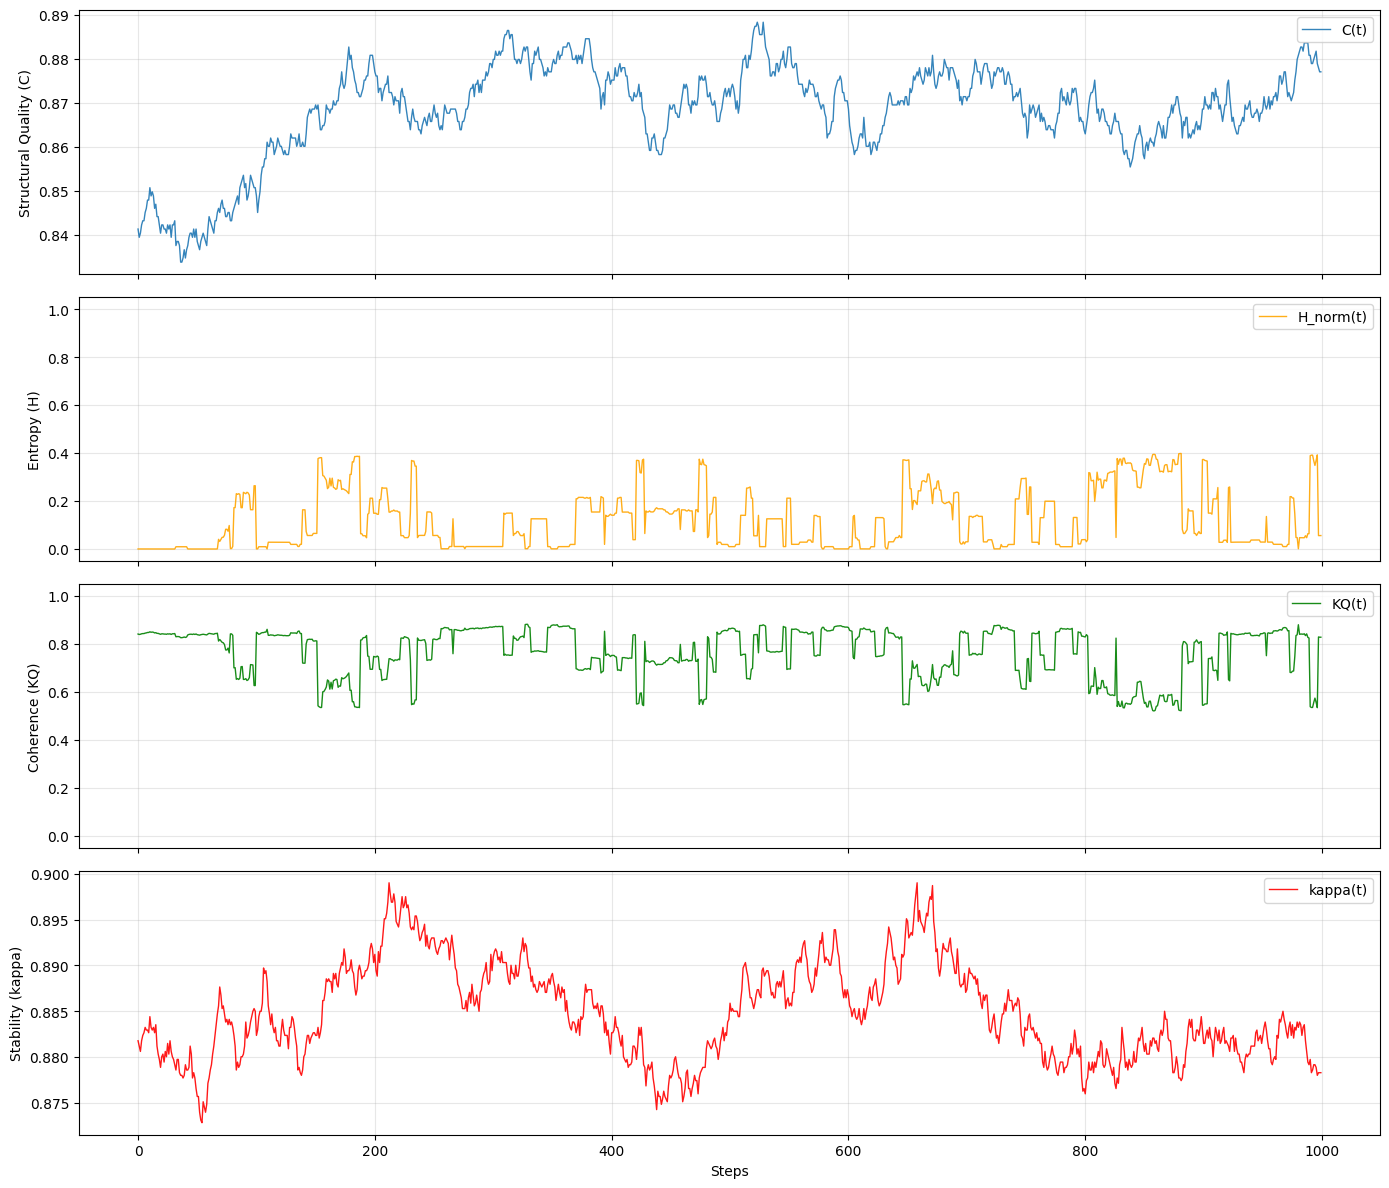

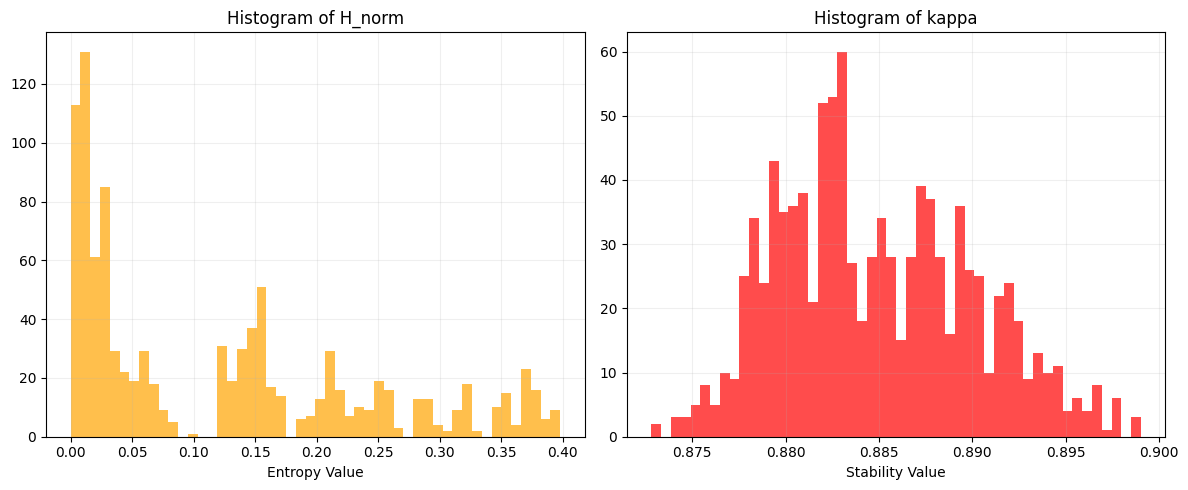

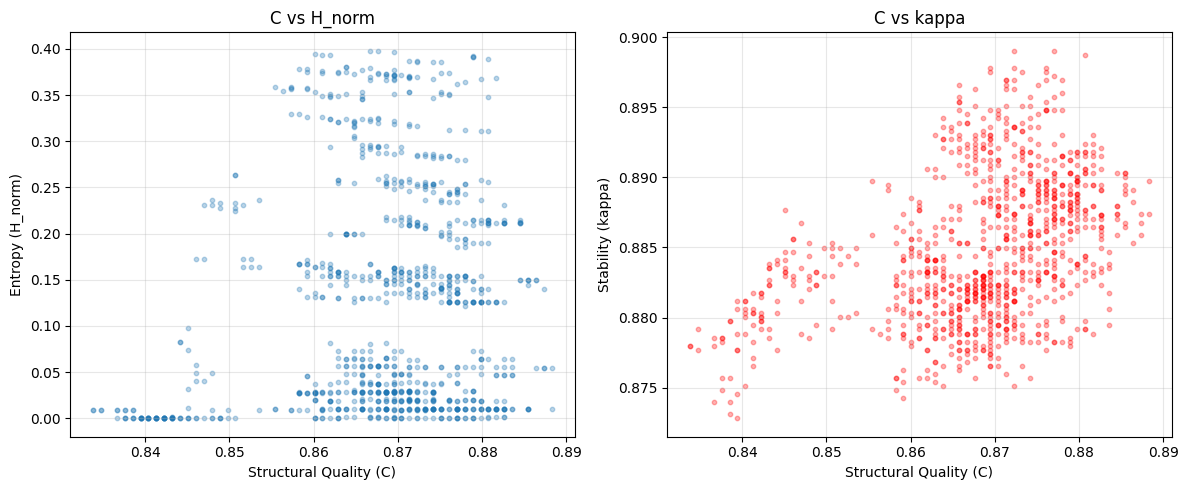


Experiment completed successfully.


In [20]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# CELL — Upload and Run (High Sensitivity Fix)

from google.colab import files
import os

print("Please upload your DIMACS .cnf file:")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded.")
else:
    cnf_path = list(uploaded.keys())[0]
    print(f"File uploaded: {cnf_path}")

    # Load Problem
    try:
        validate_dimacs_file(cnf_path)
        # Auto-detect if it's a standard SAT instance
        problem = QT3SATInstance(cnf_path)
    except NameError:
        problem = QTSATBase(cnf_path)

    # ---------------------------------------------------------
    # PARAMETER TUNING FOR SAT
    # ---------------------------------------------------------
    # For large SAT instances (e.g. >1000 clauses), a single flip
    # changes quality C(x) by very little (1/M ~ 0.0002).
    # We need a VERY HIGH beta to make Entropy sensitive to this.
    # Try: 1000, 5000, or even 10000.
    # ---------------------------------------------------------
    high_beta = 5000.0

    steps = 1000
    print(f"Running QT Complexity Benchmark (Beta={high_beta})...")

    results = run_qt_complexity_benchmark(
        problem,
        steps=steps,
        seed=42,
        max_neighbors_entropy=32,
        entropy_beta=high_beta,  # INCREASED to see landscape details
        kappa_window=50          # Slightly larger window for stability smoothing
    )

    # Compute Indices
    summary = compute_qt_complexity_index(results)

    print("\n--- QT SAT Experiment Summary ---\n")
    for k, v in summary.items():
        print(f"{k}: {v:.6f}")

    # Plot
    print("\nGenerating plots...")
    try:
        # Force re-import or re-definition if plotting failed before
        if 'plot_timeseries' in globals():
            plot_timeseries(results)
            plot_histograms(results)
            plot_scatter(results)
        else:
            print("Plotting functions not found. Make sure Cell 15 is run.")
    except Exception as e:
        print(f"Plotting error: {e}")

    print("\nExperiment completed successfully.")

In [21]:
# Author: Artem Brezgin (C) 2025 Spanda Foundation
# FIXED CELL — Save QT Results + Stable ZIP Download in Colab

import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from datetime import datetime
import shutil

def save_qt_experiment(cnf_path: str, results: dict, summary: dict):
    """
    Saves all QT experiment outputs into a ZIP archive and downloads it reliably.
    """

    # -----------------------------------------
    # Prepare output directory
    # -----------------------------------------
    base_name = os.path.basename(cnf_path).replace('.cnf', '')
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    out_dir = f"/content/QT_Results/{timestamp}_{base_name}"
    os.makedirs(out_dir, exist_ok=True)
    print(f"[INFO] Saving results to: {out_dir}")

    # -----------------------------------------
    # Save summary.json
    # -----------------------------------------
    with open(f"{out_dir}/summary.json", "w") as f:
        json.dump(summary, f, indent=4)

    # -----------------------------------------
    # Save metrics.csv
    # -----------------------------------------
    df = pd.DataFrame({
        "C": results["C_series"],
        "H_norm": results["H_series"],
        "KQ": results["KQ_series"],
        "kappa": results["kappa_series"],
    })
    df.to_csv(f"{out_dir}/metrics.csv", index=False)

    # -----------------------------------------
    # Save PNG plots
    # -----------------------------------------
    # Time series
    fig = plt.figure(figsize=(14, 10))
    plt.subplot(4, 1, 1)
    plt.plot(results["C_series"]); plt.title("C(t)")
    plt.subplot(4, 1, 2)
    plt.plot(results["H_series"]); plt.title("H_norm(t)")
    plt.subplot(4, 1, 3)
    plt.plot(results["KQ_series"]); plt.title("KQ(t)")
    plt.subplot(4, 1, 4)
    plt.plot(results["kappa_series"]); plt.title("kappa(t)")
    plt.tight_layout()
    fig.savefig(f"{out_dir}/timeseries.png")
    plt.close(fig)

    # Histograms
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(results["H_series"], bins=30)
    plt.title("Histogram of H_norm")
    plt.subplot(1, 2, 2)
    plt.hist(results["kappa_series"], bins=30)
    plt.title("Histogram of kappa")
    plt.tight_layout()
    fig.savefig(f"{out_dir}/histograms.png")
    plt.close(fig)

    # Scatter
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(results["C_series"], results["H_series"], s=8)
    plt.title("C vs H_norm")
    plt.subplot(1, 2, 2)
    plt.scatter(results["C_series"], results["kappa_series"], s=8)
    plt.title("kappa vs C")
    plt.tight_layout()
    fig.savefig(f"{out_dir}/scatter.png")
    plt.close(fig)

    # -----------------------------------------
    # Create ZIP in a robust way
    # -----------------------------------------
    zip_path = f"{out_dir}.zip"
    shutil.make_archive(out_dir, "zip", out_dir)

    abs_zip = os.path.abspath(zip_path)
    print(f"[INFO] ZIP created at: {abs_zip}")
    print(f"[INFO] ZIP size: {os.path.getsize(abs_zip)} bytes")

    # -----------------------------------------
    # Attempt automatic download
    # -----------------------------------------
    try:
        print("[INFO] Downloading ZIP...")
        files.download(abs_zip)
        print("[SUCCESS] ZIP download started.")
    except Exception as e:
        print("[WARNING] Auto-download failed:", e)
        print(f"[INFO] You can manually download the file here:\n{abs_zip}")

    return abs_zip


In [22]:
save_qt_experiment(cnf_path, results, summary)

[INFO] Saving results to: /content/QT_Results/20251130_231316_uuf250-090
[INFO] ZIP created at: /content/QT_Results/20251130_231316_uuf250-090.zip
[INFO] ZIP size: 316900 bytes
[INFO] Downloading ZIP...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[SUCCESS] ZIP download started.


'/content/QT_Results/20251130_231316_uuf250-090.zip'